<a href="https://colab.research.google.com/github/gmoraissc/Projetos_de_Data_Science/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALLATIONS

In [6]:
pip install emoji

     |████████████████████████████████| 174 kB 3.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=48d1da342799b331de3ed1b6267218b457f1f845d46b6a0ff8f299b27ad5441f
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [9]:
!pip install xlsxwriter

  Using cached XlsxWriter-3.0.2-py3-none-any.whl (149 kB)


IMPORTS

In [10]:
# imports
import pandas as pd
import numpy as np
import tweepy, nltk, json, os, csv, xlsxwriter, pytz, re
from pandas import ExcelWriter as ExcelWriter
from pathlib import Path
from datetime import datetime, date, timedelta
from csv import writer
from abc import ABCMeta, abstractmethod
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import heapq, string
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
class auth_twitter(object):
  
  def __init__(self):
    pass

  def parametros_de_acesso(self, arquivo):
    
    self.__arquivo = arquivo

    with open (arquivo, 'r') as arquivo:
      texto = arquivo.readlines()[0].split(',')
    
    access_token = texto[0].split('=')[1]
    access_token_secret = texto[1].split('=')[1]
    bearer_token = texto[2].split('=')[1]
    consumer_key = texto[3].split('=')[1]
    consumer_secret = texto[4].split('=')[1]

    arquivo.close()

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)
    
    return api

DATA EXCTRACTION

In [175]:
class pesquisar_tweets(object):

  def __init__(self):
    pass

  def por_termo(self, query, result_type='recent', count=int(100)):
    
    global api

    self.__query = query
    self.__result_type = result_type
    self.__count = count

    resultados_da_pesquisa = []

    for status in tweepy.Cursor(api.search,
                                q=self.__query,
                                result_type=self.__result_type,
                                count=self.__count).items():
                                
                                resultados_da_pesquisa.append(status)

    return resultados_da_pesquisa, result_type
 
  def por_usuario(self, participante, result_type='recent', count=int(100)):
    
    global api, participantes_camarote, participantes_pipoca

    self.__participante = participante
    self.__result_type = result_type
    self.__count = count
    
    tipo_participante = informacoes_de_participantes().checar_tipo_participante(participante)

    resultados_da_pesquisa = []

    for status in tweepy.Cursor(api.user_timeline,
                                screen_name=self.__participante,
                                result_type=self.__result_type,
                                exclude_replies=False).items(self.__count):
                                
                                resultados_da_pesquisa.append(status)

    return resultados_da_pesquisa, result_type, tipo_participante

  def por_usuarios(self, participantes, result_type='recent', count=int(100)):
    
    global api

    self.__participantes = participantes
    self.__result_type = result_type
    self.__count = count
    
    resultados_da_pesquisa = []

    for participante in self.__participantes:

      for status in tweepy.Cursor(api.user_timeline,
                                  screen_name=participante,
                                  result_type=self.__result_type,
                                  exclude_replies=False).items(self.__count):
                                  
                                  resultados_da_pesquisa.append(status)

    return resultados_da_pesquisa, result_type, 'Todos'

  def infos_do_usuario(self, usuario):
  
    global api

    informacoes_hist_participante = []

    self.__user_results = api.get_user(usuario)

    extracao = corrigir_timezone(tipo='hora')
    
    participante = self.__user_results.name
    twitter = self.__user_results.screen_name
    seguidores = self.__user_results.followers_count
    seguindo = self.__user_results.friends_count
    numero_de_listados = self.__user_results.listed_count
    n_tweets_favoritados = self.__user_results.favourites_count
    num_de_tweets_totais = self.__user_results.statuses_count
    verificado = self.__user_results.verified

    informacoes_hist_participante.append({'participante': str(participante),
                                          'twitter': str(twitter),
                                          'n_seguidores': int(seguidores),
                                          'n_seguindo': int(seguindo),
                                          'n_de_listados': int(numero_de_listados),
                                          'n_tweets_favoritados': int(n_tweets_favoritados),
                                          'num_de_tweets_totais': int(num_de_tweets_totais),
                                          'verificado': bool(verificado),
                                          'data': extracao})
    
    return informacoes_hist_participante

  def historico_participante(self, participantes):

    """A partir da busa por usuario, ele itera em uma lista e faz uma varredura por todos os participantes"""

    historico_info_participantes = []

    for participante in participantes:
      _ = pesquisar_tweets().infos_do_usuario(participante)
      historico_info_participantes.extend(_)
    
    return historico_info_participantes

DATA ORGANIZATION

In [201]:
class organizar_coletas_de_tweets(object):

  def __init__(self):
    pass

  def criar_dicionario(self, tweets_status, tipo):
      
    d1 = corrigir_timezone(tipo='data')

    self.tweets_status = tweets_status

    dicionario = {}

    for each_json_tweet in tweets_status:
      _ = json.dumps(each_json_tweet._json)
      
      if d1 not in dicionario.keys():
        tweet = {d1: [json.loads(_)]}
        dicionario.update(tweet)
        
      else:
        dicionario[d1].append(json.loads(_))
      
    return dicionario, tipo

  def dataframe_tweets(self, dicionario, tipo_de_pesquisa, multipla=False):
    
    d1 = corrigir_timezone(tipo='data')
    
    self.__tipo_de_pesquisa = tipo_de_pesquisa

    lista = []

    for i in range(0, len(dicionario[d1])):

          tweet_id = dicionario[d1][i]['id']
          text = dicionario[d1][i]['text']
          favorite_count = dicionario[d1][i]['favorite_count']
          retweet_count = dicionario[d1][i]['retweet_count']
          created_at = dicionario[d1][i]['created_at']
          hashtags = dicionario[d1][i]['entities']['hashtags']
          user_mentions = dicionario[d1][i]['entities']['user_mentions']
          name = dicionario[d1][i]['user']['name']
          screen_name = dicionario[d1][i]['user']['screen_name']

          lista.append({'tweet_id': str(tweet_id),
                        'text': str(text),
                        'favorite_count': int(favorite_count),
                        'retweet_count': int(retweet_count),
                        'created_at': created_at,
                        'user_mentions': user_mentions,
                        'name': name,
                        'screen_name': screen_name})
          
    tweet_json_ = pd.DataFrame(lista, columns = 
                              ['tweet_id', 'text', 
                                'favorite_count', 'retweet_count', 
                                'created_at', 'hashtags', 
                                'user_mentions', 'name',
                                'screen_name'])
    
    if multipla == False:
      
      tipo_participante = informacoes_de_participantes().checar_tipo_participante(screen_name)
    
    else:
      
      tipo_participante = 'Todos'

    return tweet_json_, tipo_participante, tipo_de_pesquisa


  def dataframe_dos_participantes(self, informacoes_hist_participante):

      self.__informacoes_hist_participante = informacoes_hist_participante

      dados_participantes = pd.DataFrame(informacoes_hist_participante, columns = 
                                      ['participante', 'twitter', 'n_seguidores', 
                                      'n_seguindo','n_de_listados', 'n_tweets_favoritados',
                                      'num_de_tweets_totais', 'verificado', 'data'])
      
      return dados_participantes, 'historico', None

FILE HANDLING

In [116]:
def salvar_arquivo(dataframe, tipo_consulta, tipo_participante):
    
    data_extracao = corrigir_timezone(tipo='data')
    dir_csvs = f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames/'

    if tipo_consulta == 'historico':
           
      file_variable_ = dir_csvs + 'Participantes'
      file_name = 'historico.csv'
      file_path_ = file_variable_ + "/" + file_name
      diretorios(file_variable=file_variable_, file_path=file_path_)
    
    else:

      file_variable_ = dir_csvs + "/" + tipo_participante  + "/" + tipo_consulta + "/" + data_extracao
      file_name = tipo_participante[0:3] + "_" + tipo_consulta[0:3] + "_" + data_extracao + '.csv'
      file_path_ = file_variable_ + "/" + file_name
      diretorios(file_variable=file_variable_, file_path=file_path_)
       
def diretorios(file_variable, file_path):

  if not os.path.exists(file_variable):
    os.makedirs(file_variable)
    dataframe.to_csv(file_path, index=False)

  else:
    with open(file_path, 'a') as f_object:
      writer_object = writer(f_object, delimiter=',')
      linhas = []
      
      for row in range(0, len(dataframe)):
        linhas.append([row for row in dataframe.iloc[row]])
        writer_object.writerow(linhas[row])

      f_object.close()

PARTICIPANTS INFORMATIONS

In [194]:
class informacoes_de_participantes(object):

  def __init__(self):
    pass

  @staticmethod
  def checar_tipo_participante(usuario):
      if usuario in participantes_camarote:
        return 'Camarote'
      elif usuario in participantes_pipoca:
        return 'Pipoca'
      elif usuario in perfis_oficiais_bbb:
        return 'PerfilOficial'
      else:
        return 'Publico'

DATE WRANGLING

In [71]:
@abstractmethod
def corrigir_timezone(tipo):
  
  utcmoment_naive = datetime.utcnow()
  utcmoment = utcmoment_naive.replace(tzinfo=pytz.utc)
  tz = 'America/Sao_Paulo'
  extracao = utcmoment.astimezone(pytz.timezone(tz)) - timedelta(hours=0, minutes=60)
  data_de_extracao = extracao.date().strftime("%d%m%Y")

  if tipo == 'data':
    return data_de_extracao
  
  elif tipo == 'hora':
    return extracao

TEXT OPERATIONS

In [28]:
# metodo para adicionar termos mais relevantes para o modelo *publico e por participante, exemplo, memes
#termos mais frequentes para determinado participante
class termos_de_pesquisa(object):
  
  def __init__(self):
    pass

  def termos(self):
    
    termos_de_pesquisa = {'BigBrotherBrasil': {'BBB', 'BBB22', 'BIG BROTHER BRASIL', 'BIG BROTHER BRASIL 2022','#REDEBBB', '#BBB', '#BBB22'},
         'Participantes': {'Arthur': ['Arthur', 'Artur', 'Aguiar', 'Arthur Aguiar', '\u2747\ufe0f', '#TeamAguiar', '#TeamArthurAguiar'],
                           'Naiara Azevedo': ['Naiara', 'Azevedo', '1f4b8', '#TeamNaiara', 'Nai', 'cantora'],
                           'Pedro Scooby': ['Pedro', 'Scooby', '1f30a', '#TeamScooby', '#TimeScooby', '1f499'],
                           'Brunna Gonçalves': ['Brunna', 'Gonçalves', '1f984', '#BBBRUNNA', 'BBBrunna'],
                           'Paulo André': ['Paulo', 'André', '1f3c1', '#TeamPauloAndré', 'TeamPauloAndre'],
                           'Maria': ['Maria', '1f40d	', '#TEAMMARIA', 'TIME MARIA', 'MARICONAS'],
                           'Jade Picon': ['Jade', 'Picon', '1f32a\ufe0f', 'furacão', '#TeamJade', 'Picão', 'KdJade', 'Picões', 'Furacao'],
                           'Douglas Silva': ['Douglas', 'Silva', '1f3b2', 'dado', 'dadinho', '#TeamDouglasSilva', '1f44a\U0001f3ff'],
                           'Linn da Quebrada': ['Linn', 'Quebrada', '1f9dc\u200d\u2640\ufe0f', '1f9dc\U0001f3ff\u200d\u2640\ufe0f',
                                                '1f9dc\U0001f3fb\u200d\u2640\ufe0f', '1f9dc\U0001f3fe\u200d\u2640\ufe0f', '1f9dc\U0001f3fc\u200d\u2640\ufe0f',
                                                '1f9dc\U0001f3fd\u200d\u2640\ufe0f', '1f9dc', '1f9dc\U0001f3ff', '1f9dc\U0001f3fb', '1f9dc\U0001f3fe',
                                                '1f9dc\U0001f3fc', '1f9dc\U0001f3fd', '#TeamLinn', '#linndonas', '#LinnDonas'],
                           'Tiago Abravanel': ['Tiago', 'Abravanel', '1f43b', '#TeamAbrava', '#TeamAbravanel', '1f9f8'],
                           'Laís Caldas': ['Laís', 'Caldas', '1f462', '#TeamLais', '#TeamLaís', 'Time Lais', '1f49a'],
                           'Luciano Estevan': ['Luciano', 'Estevan', '1f981', '#TeamLucianoEstevan', 'Lu', '1f346'],
                           'Jessilane': ['Jessilane', '1f9ec', 'Jessi', '#TeamJessi', '#TimeJessi', '1f49c', 'Charmanders'],
                           'Eliezer': ['Eliezer', '1F437', 'Eli', '#TeamEli', '1F953', '1F416', '1F43D'],
                           'Eslovênia Marques': ['Eslovênia', 'Eslováquia', 'Marques', 'Eslô', '1f1f8\U0001f1ee',
                                                 'Time Eslo', 'Team Eslo', '#TimeEslô', '#TeamEslô', 'Eslovenia'],
                           'Bábara Heck': ['Bárbara', 'Heck', '1f980', '#TeamBá', 'TeamBá', 'TimeBá',
                                           'TimeBa', 'TeamBa', 'TeamBah', 'BBBah', 'Bá', 'Ba', '1f9a6'],
                           'Rodrigo Mussi': ['Rodrigo Mussi', 'Mussi', 'Rodrigo', 'TEAM MUSSI', '#TeamMussi',
                                             '#TimeMussi', '1f977\U0001f3ff', '1f977', '1f977\U0001f3fb',
                                             '1f977\U0001f3fe', '1f977\U0001f3fc', '1f977\U0001f3fd', 'ninja', 'ninjas', 'TEAM NINJA'],
                           'Natália Deodato': ['Natália', 'Deodato', '#TeamNaty', '#TimeNaty', 'Naty', 'vitilindos',
                                               '1f483', '1f483\U0001f3ff', '1f483\U0001f3fb',
                                               '1f483\U0001f3fe', '1f483\U0001f3fc', '1f483\U0001f3fd'],
                           'Vinicius': ['Vinicius', 'TeamVyni', '#TimeVyni', '#TeamVyni', '1f4a1'],
                           'Lucas Bissoli': ['Lucas', 'Bissoli', '#TimeBissoli', '#TeamBissoli', 
                                             '1f3c4\u200d\u2642\ufe0f', '1f3c4\U0001f3ff\u200d\u2642\ufe0f', 
                                             '1f3c4\U0001f3fb\u200d\u2642\ufe0f', '1f3c4\U0001f3fe\u200d\u2642\ufe0f',
                                             '1f3c4\U0001f3fc\u200d\u2642\ufe0f', '1f3c4\U0001f3fd\u200d\u2642\ufe0f',
                                             '1f3c4', '1f3c4\U0001f3ff', '1f3c4\U0001f3fb', '1f3c4\U0001f3fe',
                                             '1f3c4\U0001f3fc', '1f3c4\U0001f3fd', '1f3c4\u200d\u2640\ufe0f',
                                             '1f3c4\U0001f3ff\u200d\u2640\ufe0f', '1f3c4\U0001f3fb\u200d\u2640\ufe0f',
                                             '1f3c4\U0001f3fe\u200d\u2640\ufe0f', '1f3c4\U0001f3fc\u200d\u2640\ufe0f',
                                             '1f3c4\U0001f3fd\u200d\u2640\ufe0f']}}

    #termos_a_analisar = []

    #avaliador_de_termos()

    #return termos_de_pesquisa_BBB

    analisador_de_termos(termos_de_pesquisa_participantes)

  def analisador_de_termos(self, termos_atuais, termos_novos):

    self.__termos_atuais = termos_atuais
    self.__termos_novos = termos_novos

    for termo in termos_atuais:
      # if novo termo ajudar a explicar:
      # append
      # if len(termos) > limite:
      # termo_a_remover = ()
      # for termo in termos atuais atualizado:
      # termo_a_remover['explicacao'] < min_a_explicar:
      # termos_atuais.pop(termo_a_remover)

  def tendencia(self, termo_novo):

    self.termo_novo = termo_novo
    pass

  def correlacao_participantes(self):
    pass

IndentationError: ignored

In [65]:
dicionario_participantes = {'@Aguiarthur': 'Arthur Aguiar', 
                            '@Naiarazevedo': 'Naiara Azevedo',
                            '@PedroScooby': 'Pedro Scooby',
                            '@brunnagoncalves': 'Bruna Gonçalves',
                            '@iampauloandre': 'Paulo André',
                            '@eumaria': 'Maria',
                            '@jadepicon': 'Jade Picon',
                            '@Silva_DG': 'Douglas Silva',
                            '@linndaquebrada': 'Linn da Quebrada',
                            '@TiagoAbravanel': 'Tiago Abravanel',
                            '@Dra_laiscaldass': 'Laís Caldas',
                            '@LucianoEstevan': 'Luciano Estevan',
                            '@a_jessilane': 'Jessilane',
                            '@eusouoeli': 'Eliezer',
                            '@eslomarques': 'Eslovênia Maques',
                            '@bbaheck': 'Bábara Heck',
                            '@oficialmussi': 'Rodrigo Mussi',
                            '@oficial_deodato': 'Natália Deodato',
                            '@vyniof': 'Vinicius',
                            '@LucasBissoli_': 'Lucas Bissoli'}

participantes_camarote = ['Aguiarthur', 'Naiarazevedo', 'PedroScooby', 'brunnagoncalves', 
                          'iampauloandre', 'eumaria', 'jadepicon', 'Silva_DG', 'linndaquebrada', 'TiagoAbravanel']

participantes_pipoca = ['Dra_laiscaldass', 'LucianoEstevan', 'a_jessilane', 'Eli', 'eslomarques', 
                        'bbaheck', 'oficialmussi', 'oficial_deodato', 'vyniof', 'LucasBissoli_']

participantes_camarote_twitter = ['@Aguiarthur', '@Naiarazevedo', '@PedroScooby', '@brunnagoncalves', 
                          '@iampauloandre', '@eumaria', '@jadepicon', '@Silva_DG', '@linndaquebrada', '@TiagoAbravanel']

participantes_pipoca_twitter = ['@Dra_laiscaldass', '@LucianoEstevan', '@a_jessilane', '@eusouoeli', '@eslomarques', 
                        '@bbaheck', '@oficialmussi', '@oficial_deodato', '@vyniof', '@LucasBissoli_']

perfis_oficiais_bbb = ['bbb']

participantes_total = []
participantes_total.extend(participantes_pipoca)
participantes_total.extend(participantes_camarote)

TESTES

In [34]:
#d1 = date.today().strftime("%d/%m/%Y")
d1 = corrigir_timezone(tipo='data')

In [35]:
api = auth_twitter().parametros_de_acesso('/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/auth.txt')

PESQUISAS POR NOME DE USUARIO

In [59]:
tweets, tipo_de_pesquisa, tipo_participante = pesquisar_tweets().por_usuario(participante='@PedroScooby', result_type='recent')
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().dataframe_tweets(dicionario, tipo_de_pesquisa)
salvar_arquivo(tipo_consulta=tipo_de_pesquisa, dataframe=dataframe, tipo_participante=tipo_participante)

PESQUISAS POR NOME DE USUARIOS

In [197]:
tweets, tipo_de_pesquisa, tipo_participante = pesquisar_tweets().por_usuarios(participantes=participantes_total, result_type='recent', count=100)
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().dataframe_tweets(dicionario, tipo_de_pesquisa, multipla=True)
salvar_arquivo(tipo_consulta=tipo_de_pesquisa, dataframe=dataframe, tipo_participante=tipo_participante)

HISTÓRICO DOS PARTICIPANTES

In [117]:
dataframe, tipo_de_pesquisa, tipo_de_participante= organizar_coletas_de_tweets().dataframe_dos_participantes(pesquisar_tweets().historico_participante(participantes_total))
salvar_arquivo(dataframe=dataframe, tipo_consulta=tipo_de_pesquisa, tipo_participante=tipo_de_participante)

PESQUISA POR TERMO

In [158]:
tweets, tipo_de_pesquisa = pesquisar_tweets().por_termo(query=(' '.join([str(item) for item in termos_de_pesquisa['BigBrotherBrasil']]).replace(' ', ' OR ')), result_type='popular')
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().dataframe_tweets(dicionario, tipo_de_pesquisa)
salvar_arquivo(tipo_participante=tipo_participante, tipo_consulta=tipo_de_pesquisa, dataframe=dataframe)

PESQUISA PERFIL OFICIAL

In [ ]:
tweets, tipo_de_pesquisa, tipo_participante = pesquisas_de_tweets().pesquisar_por_usuario(participante='@bbb', result_type='recent')
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario_pesquisas(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dataframe(dicionario, tipo_de_pesquisa)
#organizar_coletas_de_tweets().salvar_csvs_no_diretorio(tipo_participante, tipo_de_pesquisa, dataframe)

NOVAS FUNCIONALIDADES

In [ ]:
# em média, quantos seguidores ganha após um tweet positivo? e quantos perde após um tweet negativo?
# modelo de classificação baseado na popularidade do participante
# prob de ser eliminado no paredão de acordo com o atual nível de popularidade
# append no data frame para coletas automáticas!

VISUALIZAÇÕES GRÁFICAS

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
df = pd.read_csv(f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames/Participantes/historico.csv')
df['Data_ajustada'] = pd.to_datetime(df['data']).apply(lambda x: x.date())
df['tipo_participante'] = df['twitter'].apply(lambda x: 'camarote' if x in participantes_camarote else 'pipoca')
df

NameError: ignored

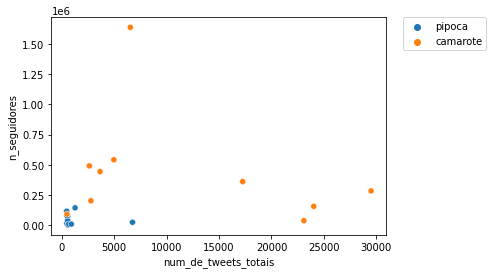

In [ ]:
sns.scatterplot(data=df,
             x='num_de_tweets_totais',
             y='n_seguidores',
             hue='tipo_participante')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

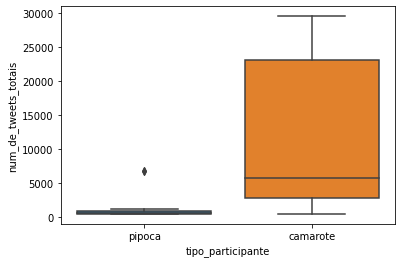

In [ ]:
sns.boxplot(data=df,
            y='num_de_tweets_totais',
            x='tipo_participante')

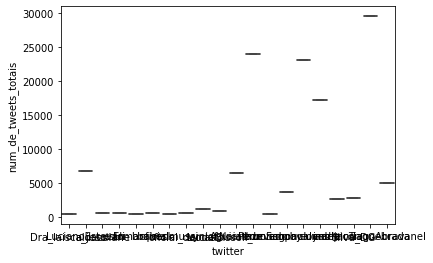

In [ ]:
sns.boxplot(data=df,
            y='num_de_tweets_totais',
            x='twitter')

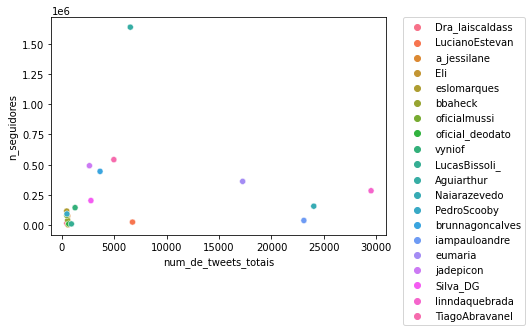

In [ ]:
sns.scatterplot(data=df,
             x='num_de_tweets_totais',
             y='n_seguidores',
             hue='twitter',
             hue_pallete=)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

No handles with labels found to put in legend.


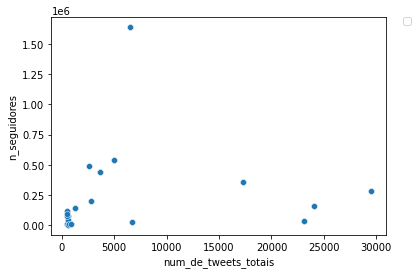

In [ ]:
sns.lineplot()

NLP

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames/Camarote/recent/20012022/Cam_rec_20012022.csv')
df.head(3)

,tweet_id,text,favorite_count,retweet_count,created_at,location,verified,hashtags,user_mentions,name,screen_name
0,1484275264813252610,"""Se você votar em mim, cê pode ter certeza que...",13,54,Thu Jan 20 21:22:54 +0000 2022,"Goiânia, Brasil",True,[],[],Naiara Azevedo 💸,Naiarazevedo
1,1484285363799703553,Pessoa: a \nO Pedro: https://t.co/B601A7gp3J,1523,124,Thu Jan 20 22:03:02 +0000 2022,"Rio de Janeiro, Brasil",True,[],[],Pedro Scooby 🌊,PedroScooby
2,1484328856454455301,@shawnblod É sobre isso… 😂,3,0,Fri Jan 21 00:55:51 +0000 2022,"Rio de Janeiro, Brasil",True,[],"[{'screen_name': 'shawnblod', 'name': 'bia sco...",Pedro Scooby 🌊,PedroScooby


In [ ]:
calendar = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
  
tweet_json['Week_day'] = tweet_json['created_at'].str.slice(0,3)
tweet_json['Month_name'] = tweet_json['created_at'].str.slice(4,7)
tweet_json['Month'] = tweet_json['Month_name'].map(calendar)
tweet_json['Day_number'] = tweet_json['created_at'].str.slice(8,10)
tweet_json['Tweeted_at_time'] = tweet_json['created_at'].str.slice(11,19)
tweet_json['Year'] = tweet_json['created_at'].str.slice(26,30)

NameError: ignored

In [ ]:
tweet_json['Data'] = str(str(tweet_json['Day_number']) + '-' + str(tweet_json['Month']) + '-' + str(tweet_json['Year']))

In [ ]:
tweet_json['Data'][0]

'0     15\n1     14\n2     14\n3     15\n4     14\n5     14\n6     15\n7     15\n8     14\n9     14\n10    15\n11    14\n12    14\n13    14\nName: Day_number, dtype: object-0     1\n1     1\n2     1\n3     1\n4     1\n5     1\n6     1\n7     1\n8     1\n9     1\n10    1\n11    1\n12    1\n13    1\nName: Month, dtype: int64-0     2022\n1     2022\n2     2022\n3     2022\n4     2022\n5     2022\n6     2022\n7     2022\n8     2022\n9     2022\n10    2022\n11    2022\n12    2022\n13    2022\nName: Year, dtype: object'

In [ ]:
pipocas_part.head(3)

,tweet_id,text,favorite_count,retweet_count,created_at,location,followers_count,friends_count,verified,hashtags,user_mentions,name,screen_name
0,1483265947175632897,@medracital ❤️,2,0,Tue Jan 18 02:32:14 +0000 2022,,3247,167,True,[],"[{'screen_name': 'medracital', 'name': 'lore 🇸...",Dra. Laís Caldas 👢,Dra_laiscaldass
1,1483265820528680961,@itscruella Pode encerrar viu? 😅🤍 https://t.co...,2,1,Tue Jan 18 02:31:44 +0000 2022,,3247,167,True,[],"[{'screen_name': 'itscruella', 'name': 'Cruell...",Dra. Laís Caldas 👢,Dra_laiscaldass
2,1483265480945287169,Contem pra gente.. o que estão achando da Laís...,125,9,Tue Jan 18 02:30:23 +0000 2022,,3247,167,True,"[{'text': 'TeamLais', 'indices': [74, 83]}, {'...",[],Dra. Laís Caldas 👢,Dra_laiscaldass


In [ ]:
word_tokenize(pipocas_part['text'])

NameError: ignored

In [ ]:
# ACOMPANHAR PAREDÕES, PROVAS, ETC (PESQUISAR PELO USUÁRIO OFICIAL DO BBBB)
tweets, tipo_de_pesquisa, tipo_participante = pesquisas_de_tweets().pesquisar_por_usuario(participante='@bbb', result_type='recent')
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario_pesquisas(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dataframe(dicionario, tipo_de_pesquisa)
organizar_coletas_de_tweets().salvar_csvs_no_diretorio(tipo_participante, tipo_de_pesquisa, dataframe)

In [ ]:
tweet_json_recents.join(tweet_json_popular, on='tweet_id')

ValueError: ignored

In [3]:
df = pd.read_csv(f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames/PerfilOficial/popular/20012022/Per_pop_20012022.csv')
textos = [text for text in df['text']]
textos

NameError: ignored

In [1]:
def pre_processar_texto(tweets):

  texto_processado = []

  for tweet in tweets:
    sem_link_nem_espaco = remover_https_e_espacamento(tweets)
    tokenizado = tokenizar_texto(sem_link_nem_espaco)
    sem_pontuacao = remover_pontuacao(tokenizado)  
    sem_stopwords = remover_stopwords(sem_pontuacao)
    texto_processado.append(sem_stopwords)
  
  return texto_processado
  #dataset = nltk.sent_tokenize(texto_sem_stopwords)
  #text = "He was carefully disguised but captured quickly by police."
  #re.findall(r"\w+ly\b", text)
  # ['carefully', 'quickly']
  #for i in range (len(dataset)):
      #dataset[i] = dataset[i].lower() #botar tudo para minuscula
      #dataset[i] = re.sub(r'W', ' ', dataset[i]) substituir o que não for palavra por espaço? e os emojis?
      #dataset[i] = re.sub(r's+', ' ', dataset[i]) #substituir quebras de linhas por espaço simples
  
  #return #dataset

def remover_https_e_espacamento(texto):

  texto_sendo_analisado = []
  
  for i in range(0, len(texto)):
    sem_https = re.sub(r'http\S+', '', texto[i])
    sem_caractere_de_espacamento = re.sub(r'\n+', '', sem_https)
    texto_sendo_analisado.append(sem_caractere_de_espacamento)
  
  return texto_sendo_analisado

def tokenizar_texto(texto):
    
    texto_tokenizado = [word for word in word_tokenize(texto)]

    return texto_tokenizado

def remover_pontuacao(texto):
  
  pontuacao = [c for c in string.punctuation]
  texto_sem_pontuacao = [_ for _ in textos if _ not in pontuacao]

  return texto_sem_pontuacao

def remover_stopwords(texto):

  stopwords_ptbr = nltk.corpus.stopwords.words('portuguese')
  texto_sem_stopwords = [word for word in textos if word not in stopwords_ptbr]

  return texto_sem_stopwords

def histograma(self, dataset):

  self.dataset = dataset

  word2count = {}
  for data in dataset:
      words = nltk.word_tokenize(data)
      for word in words:
          if word not in word2count.keys():
              word2count[word] = 1
          else:
              word2count[word] += 1
  return word2count

def ordenacao(self, dataset):

  self.dataset = dataset
  freq_words = heapq.nlargest(50,word2count, key=word2count.get)
  
  return freq_words

def criar_bow(self, dataset):
  
  x = []
  
  for data in dataset:
    vector = []
    for word in freq_words:
        if word in nltk.word_tokenize(data):
            vector.append(1) 
        else:
            vector.append(0) 
    x.append(vector)
  
  y = np.asarray(x)

  return y

In [2]:
pre_processar_texto(textos)

NameError: ignored